In [20]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read the tweets.csv file into a datframe
df = pd.read_csv("datasets/tweet.csv")
print('Shape: ', df.shape)
df.head()

Shape:  (137, 6)


,created_at,id,full_text,lang,retweet_count,favorite_count
0,Sat Feb 01 10:32:07 +0000 2014,429562803557376001,Photo “Black and white” by Kouji Tomihisa (@to...,ht,0,1
1,Sat Feb 01 10:24:30 +0000 2014,429560885544091648,Photo “Intersection | Tokyo” by Navid Baraty (...,en,0,1
2,Thu Jan 30 16:15:17 +0000 2014,428924385559199744,Photo “Heavy winter” by Mikael Sundberg #500px...,en,0,2
3,Sun Nov 15 06:28:49 +0000 2015,665778459680092160,"RT @paulocoelho: ""Même quand la blessure guéri...",fr,0,0
4,Fri Aug 08 10:41:59 +0000 2014,497694201484935168,http://t.co/VsheNtFNw8,und,0,2


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      137 non-null    object
 1   id              137 non-null    int64 
 2   full_text       137 non-null    object
 3   lang            137 non-null    object
 4   retweet_count   137 non-null    int64 
 5   favorite_count  137 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 6.5+ KB


In [22]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [23]:
df[(df['retweet_count'] == 0) & (df['retweet_count'] != 0)].head()

,created_at,id,full_text,lang,retweet_count,favorite_count


In [24]:
# save as new column
df['mention'] = df['retweet_count'][(df['full_text'] == 0) & (df['retweet_count'] != 0)]
# fill Nan's here as well
df['mention'] = df['mention'].fillna(0)

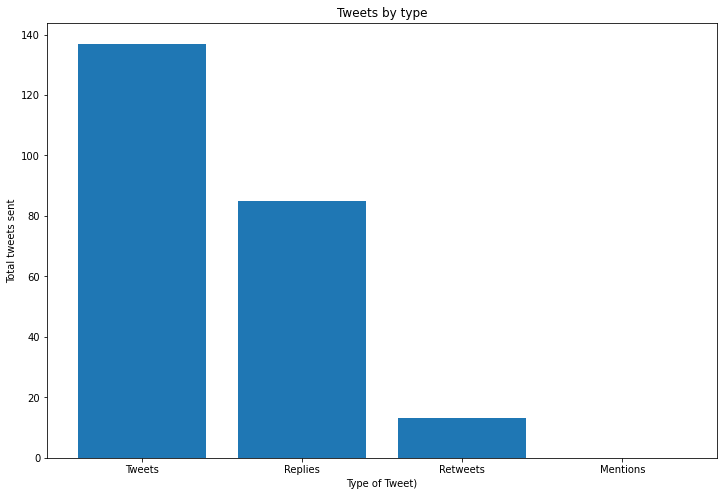

In [25]:
# create dictionary with values to plot
# the imputed zeros need to be excluded here
data = {
        'Tweets': (df['full_text'] != 0).sum(),
        'Replies': (df['favorite_count']!=0).sum(), 
        'Retweets': (df['retweet_count'] != 0).sum(),
        'Mentions':  (df['mention'] != 0).sum()
        }

names = list(data.keys())
values = list(data.values())

# plot the above data
# set the figure size
plt.figure(figsize=(12,8))

# create a countplot, ordered by count
plt.bar(names, values)

# set the labels and title
plt.xlabel('Type of Tweet)')
plt.ylabel('Total tweets sent')
plt.title('Tweets by type');

In [26]:
df['full_text'].head()

0    Photo “Black and white” by Kouji Tomihisa (@to...
1    Photo “Intersection | Tokyo” by Navid Baraty (...
2    Photo “Heavy winter” by Mikael Sundberg #500px...
3    RT @paulocoelho: "Même quand la blessure guéri...
4                               http://t.co/VsheNtFNw8
Name: full_text, dtype: object

In [27]:
df['full_text'].value_counts()

@faaajh خوشحالم برگشتی                                                                                                   1
Photo “Rêve Urbain” by Eric DRIGNY #500px http://t.co/oWeaT20tj8                                                         1
کلا زمان ر هیچ وقت درک نکردم                                                                                             1
@gh_ei721 Who? Me? HaHaHaHa https://t.co/S7M6NRszrw                                                                      1
یکی‌از کارهای روتین روزانه م اینه که بیام توییتر یسری توییت بپسندم (که اصلا م بد نیست)                                   1
                                                                                                                        ..
RT @avogado6: 反抗 https://t.co/8D11oTozhK                                                                                 1
RT @avogado6: 不安 https://t.co/haFgrGjpZZ                                                                                 1
RT @DailyHemingw

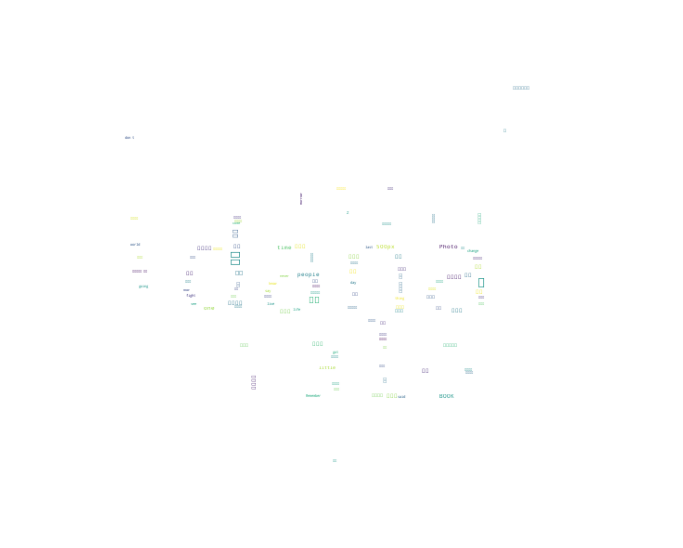

In [28]:
from wordcloud import WordCloud, STOPWORDS
import imageio

# join tweets to a single string
words = ' '.join(df['full_text'])

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

# create a twitter-style mask for the wordcloud
twitter_mask = imageio.imread('twitter_mask.png')

# add some Croatian stopwords manually
cro_stopwords = {
                'si','se','su','sa','ce','cu','za','je','ja','ti','mi','da','od','kad','sam','pa','po','ili','ali','li',
                'ako','iz','ne','nije','nisam','sad','sto','samo','ovo','ovaj','na','ima','ko','ova','koji','neki',
                'jos','jo','jer','bi','ba','kako','sve','tako', 'ga','tu','bio','onda','kao','vec', 'nesto','mogu'    
                }
STOPWORDS = STOPWORDS.union(cro_stopwords)

# generate the wordcloud
wordcloud = WordCloud(
                    stopwords = STOPWORDS,
                    background_color='white',
                    width=1800, 
                    height=1400, 
                    mask=twitter_mask
                    ).generate(no_urls_no_tags)

# set the figure size
plt.figure(figsize=(12,12))

# show the wordcloud
plt.imshow(wordcloud)
plt.axis('off');

In [29]:
# calculate number of characters in a tweet and save as new column
df['tweet_length']  = np.array([len(tweet) for tweet in df['full_text']])

print('Average number of characters per tweet:', df['tweet_length'].mean())
print('Average number of characters per reply:', df['tweet_length'][df['retweet_count'] != 0].mean())
print('Average number of characters per retweet:', df['tweet_length'][df['favorite_count'] != 0].mean())
print('Average number of characters per mention:', df['tweet_length'][df['full_text'] != 0].mean())

Average number of characters per tweet: 83.82481751824818
Average number of characters per reply: 105.07692307692308
Average number of characters per retweet: 85.55294117647058
Average number of characters per mention: 83.82481751824818


In [30]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    # remove special characters, links from tweets
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    # predict the sentiment of a tweet using textblob
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [31]:
df['sentiment'] = np.array([analize_sentiment(tweet) for tweet in df['full_text']])

In [32]:
# construct lists with classified tweets
pos_tweets = [ tweet for index, tweet in enumerate(df['full_text']) if df['sentiment'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(df['full_text']) if df['sentiment'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['full_text']) if df['sentiment'][index] < 0]

# print percentages
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['full_text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['full_text'])))
print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['full_text'])))

Percentage of positive tweets: 16.78832116788321%
Percentage of neutral tweets: 75.18248175182482%
Percentage of negative tweets: 8.02919708029197%


In [11]:
# create a copy of the dataframe
df_time = df.copy()

# set the timestamp column as the index and delete the column
df_time.index = df_time['created_at']
del df_time['created_at']

df_time.head()

,id,full_text,lang,retweet_count,favorite_count,mention_to_user_id,tweet_length,sentiment
created_at,,,,,,,,
2014-02-01 10:32:07+00:00,429562803557376001,Photo “Black and white” by Kouji Tomihisa (@to...,ht,0,1,0.0,82,-1
2014-02-01 10:24:30+00:00,429560885544091648,Photo “Intersection | Tokyo” by Navid Baraty (...,en,0,1,0.0,84,0
2014-01-30 16:15:17+00:00,428924385559199744,Photo “Heavy winter” by Mikael Sundberg #500px...,en,0,2,0.0,69,-1
2015-11-15 06:28:49+00:00,665778459680092160,"RT @paulocoelho: ""Même quand la blessure guéri...",fr,0,0,0.0,107,0
2014-08-08 10:41:59+00:00,497694201484935168,http://t.co/VsheNtFNw8,und,0,2,0.0,22,0


In [33]:
print('Total tweets in 2014:', df_time['2014']['id'].count())
print('Total replies in 2016:', (df_time!=0)['2016']['full_text'].sum()) # zeros need to be excluded

Total tweets in 2014: 9
Total replies in 2016: 4


In [34]:
(df_time!=0).resample('AS').sum()

,id,full_text,lang,retweet_count,favorite_count,mention_to_user_id,tweet_length,sentiment
created_at,,,,,,,,
2014-01-01 00:00:00+00:00,9.0,9.0,9.0,0.0,6.0,0.0,9.0,5.0
2015-01-01 00:00:00+00:00,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2016-01-01 00:00:00+00:00,4.0,4.0,4.0,0.0,3.0,0.0,4.0,1.0
2017-01-01 00:00:00+00:00,44.0,44.0,44.0,7.0,37.0,0.0,44.0,2.0
2018-01-01 00:00:00+00:00,42.0,42.0,42.0,4.0,25.0,0.0,42.0,8.0
2019-01-01 00:00:00+00:00,5.0,5.0,5.0,0.0,2.0,0.0,5.0,1.0
2020-01-01 00:00:00+00:00,32.0,32.0,32.0,2.0,12.0,0.0,32.0,17.0


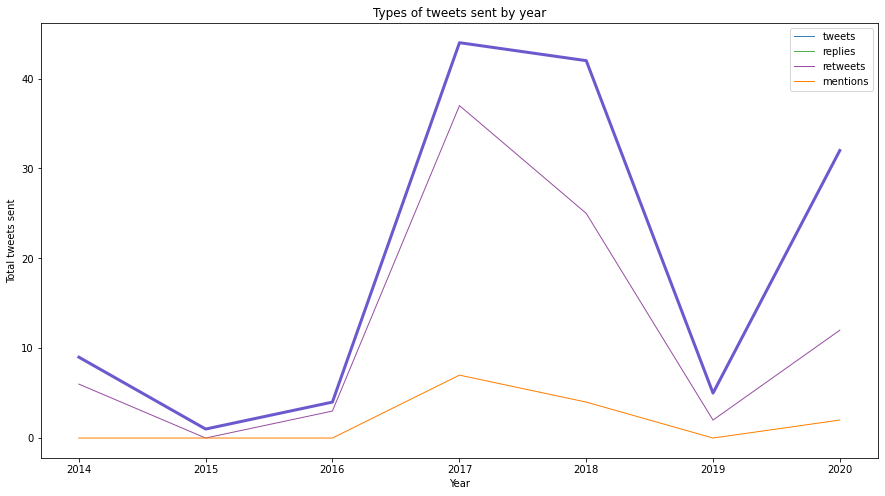

In [35]:
# plot some of the above data
# define a list of columns to plot
plot_cols = ['id', 'full_text', 'favorite_count', 'retweet_count']

# set the figure size
plt.figure(figsize=(15,8))
 
# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot
num=0
for column in df_time[plot_cols]:
    num+=1
    plt.plot((df_time!=0)[column].resample('AS').sum(), marker='', color=palette(num), linewidth=1)
    
# now re do the most important curve, but with bigger line width
plt.plot((df_time!=0)['id'].resample('AS').sum(), marker='', color='slateblue', linewidth=3)

# add a legend with custom labels
mylabels = ['tweets','replies','retweets','mentions']
plt.legend(labels = mylabels)

# add labels and title
plt.xlabel('Year')
plt.ylabel('Total tweets sent')
plt.title('Types of tweets sent by year');

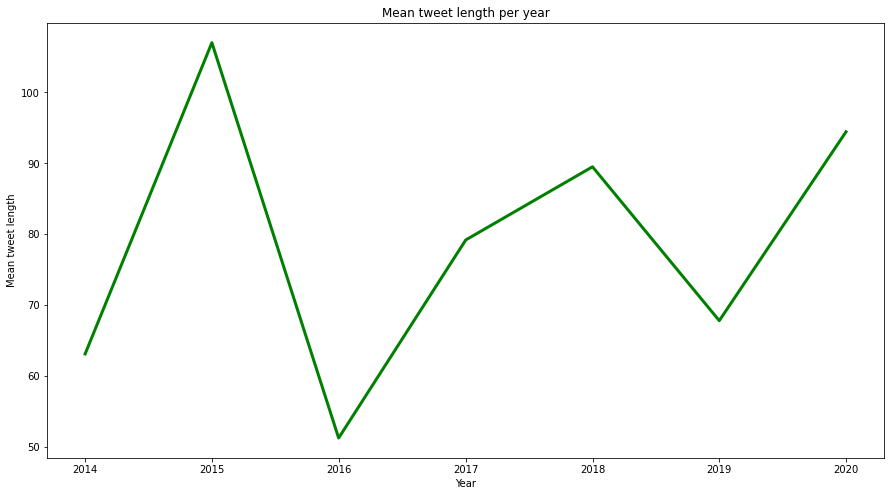

In [36]:
# set the figure size
plt.figure(figsize=(15,8))
 
# now re do the most important curve, but with bigger line width
plt.plot(df_time['tweet_length'].resample('YS').mean(), marker='', color='green', linewidth=3)

# add labels and title
plt.xlabel('Year')
plt.ylabel('Mean tweet length')
plt.title('Mean tweet length per year');

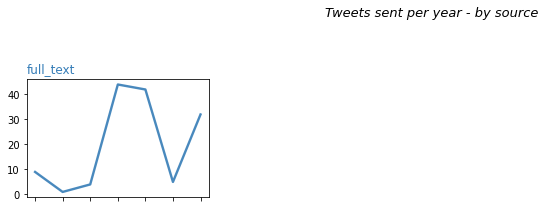

In [37]:
# get list of all source columns
# need to create a new list since the old one has been outdated with the lesser source columns merge
source_cols = list(df_time.columns[df_time.columns.str.startswith('full_text')])

# set the figure size
plt.figure(figsize=(15,10))

# multiple line plot of the yearly number of tweets per source
num=0
for column in df_time[source_cols]:
    num+=1
 
    # find the right spot on the plot
    plt.subplot(4,4, num)
    
    # plot every column, but discreet
    for v in df_time[source_cols]:
        plt.plot((df_time!=0)[v].resample('AS').sum(), marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # plot the lineplot
    plt.plot((df_time!=0)[column].resample('AS').sum(), marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # not ticks everywhere
    if num in range(13) :
        plt.tick_params(labelbottom=False)
    if num not in [1,5,9,13] :
        plt.tick_params(labelleft=False)
    
    # rotate the ticks
    plt.xticks(rotation=45, fontsize='11', horizontalalignment='right')
        
    # add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))

# add general title
plt.suptitle("Tweets sent per year - by source", fontsize=13, fontweight=0, color='black', style='italic');


In [38]:
# create new columns based on timestamp
df['weekdaynum'] = df['created_at'].dt.dayofweek
df['weekday'] = df['created_at'].dt.day_name()
df['monthdaynum'] = df['created_at'].dt.day
df['hourofday'] = df['created_at'].dt.hour

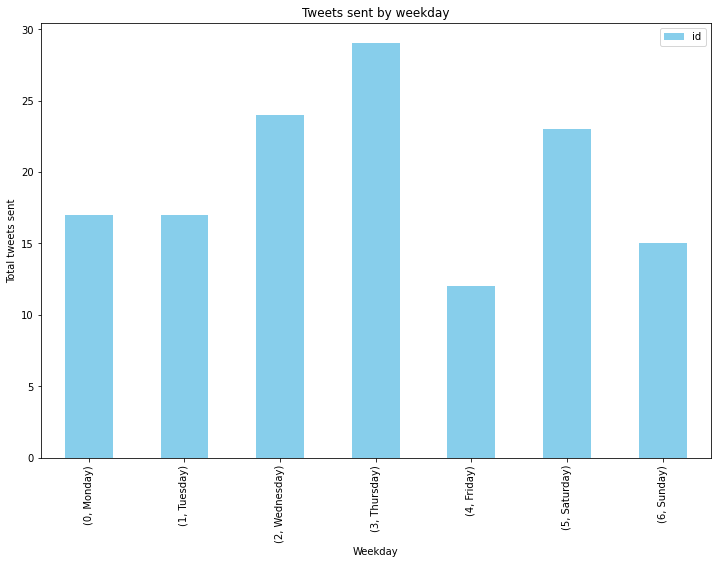

In [20]:
# create a bar plot with weekdays
df.pivot_table(index=['weekdaynum','weekday'],values='id',aggfunc='count').plot(kind='bar',figsize=(12,8),color='skyblue')

# set the labels and title
plt.ylabel('Total tweets sent')
plt.xlabel('Weekday')
plt.title('Tweets sent by weekday');

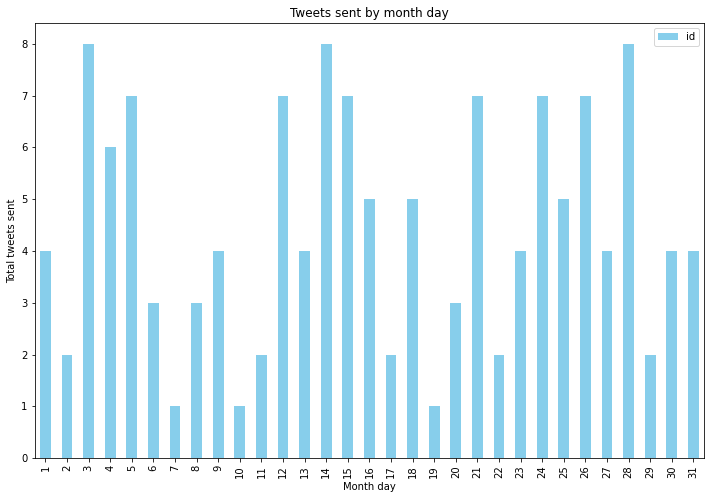

In [39]:
# create a bar plot with month days
df.pivot_table(index='monthdaynum',values='id',aggfunc='count').plot(kind='bar',figsize=(12,8),color='skyblue')

# set the labels and title
plt.ylabel('Total tweets sent')
plt.xlabel('Month day')
plt.title('Tweets sent by month day');